In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
pd.options.display.max_colwidth = None
pd.options.display.max_rows = None
skip_list = None
show_list = None

eval_data_filter = ["math-500", "gsm8k", "minerva_math", "olympiadbench"]

#----------------------------------------------------------------#
# MODIFY HERE
# show_list = ["random-1", "ours-0.5-1e-3"]
model_size = "1.5B"

#----------------------------------------------------------------#


base_dir = "/home/yifan50/rl/evaluate_outputs_test"
data = []

for model_name in os.listdir(base_dir):
    model_path = os.path.join(base_dir, model_name)
    if not os.path.isdir(model_path):
        continue

    for eval_data_name in os.listdir(model_path):
        eval_data_path = os.path.join(model_path, eval_data_name)
        if not os.path.isdir(eval_data_path):
            continue 

        for filename in os.listdir(eval_data_path):
            if filename.endswith("_metrics.json"):
                file_path = os.path.join(eval_data_path, filename)
                
                parts = filename.split("_")
                assert len(parts) == 5 
                prompt = parts[0]
                seed = parts[1].replace("seed", "")
                temperature = parts[2][1:]  
                max_token = parts[3]

                with open(file_path, "r") as f:
                    json_data = json.load(f)
                
                acc = json_data.get("acc", None)  # Extract accuracy
                
                data.append([model_name, eval_data_name, prompt, seed, temperature, max_token, acc])

df = pd.DataFrame(data, columns=["Model", "Evaluation Data", "Prompt", "Seed", "Temperature", "Max Token", "Accuracy"])

# 1.5B or 3B or 7B
if model_size == "1.5B":
    df = df[df["Model"].str.contains("1.5B")]
elif model_size == "3B":
    df = df[df["Model"].str.contains("3B")]
elif model_size == "7B":
    df = df[df["Model"].str.contains("7B")]
else:
    raise

import re
def extract_global_step(model_name):
    match = re.search(r'global_step_(\d+)', model_name)
    if match:
        step = int(match.group(1))
        return step//2 if "bs_256" in model_name else step
    else:
        raise

df = df.sort_values(by=["Model", "Prompt"], key=lambda x: x.map(extract_global_step) if x.name == "Model" else x)

columns_to_drop = [col for col in df.columns if df[col].nunique() == 1]
if columns_to_drop:
    for col in columns_to_drop:
        print(f"{col}: {df[col].iloc[0] if not df.empty else 'N/A'}")

df.drop(columns=columns_to_drop, inplace=True)
df.sort_values(by="Accuracy", ascending=False)

def strip_model_name(model_name):
    return re.sub(r'_global_step_\d+', '', model_name)

def extract_name(model_name):
    parts = model_name.split('_epoch_')
    prefix = parts[0]
    suffix = parts[1] if len(parts) > 1 else ""
    
    if 'random_1_True' in prefix or 'random_3_True' in prefix:
        return prefix
    elif suffix.endswith('mu_2'):
        return prefix
    elif 'mu_2_' in suffix:
        postfix = suffix.split('mu_2_')[-1]
        return f"{prefix}_{postfix}"
    else:
        return prefix


def parse_model_name(full_name):
    try:
        parts = full_name.split("_model_")
        prefix = parts[0]
        model_and_dataset = parts[1]
        model_parts = model_and_dataset.split("_dataset_")
        model = model_parts[0]
        dataset_raw = model_parts[1]

        if "no_std" in prefix:
            method = f"no_std_teacher"
            dataset = dataset_raw.split("tau_")[0].rstrip("_")
        elif "curr_4" in prefix:
            method = "curr_4"
            if "deepscaler" not in dataset_raw:
                dataset = dataset_raw.split("tau_")[0].rstrip("_")
            else:
                dataset = "deepscaler_10240"
        elif "curr" in prefix:
            method = "curr"
            if "deepscaler" not in dataset_raw:
                dataset = dataset_raw.split("tau_")[0].rstrip("_")
            else:
                dataset = "deepscaler_10240"
        elif "ref_128" in prefix:
            method = "ref_128"
            dataset = dataset_raw.split("tau_")[0].rstrip("_")    
        elif "replay_prob_temp_random_teacher" in prefix or "replay_prob_random_teacher" in prefix:
            if "replay_prob_temp_random_teacher" in prefix:
                if "sigma_0.5_buffer_256" in dataset_raw:
                    method = f"replay_prob_temp_random_teacher_sigma_0.5_buffer_256"
                    dataset = dataset_raw.split("tau_")[0].rstrip("_")
                elif "sigma_0.5_buffer_1024" in dataset_raw:
                    method = f"replay_prob_temp_random_teacher_sigma_0.5_buffer_1024"
                    dataset = dataset_raw.split("tau_")[0].rstrip("_")    
                else:
                    raise   
            elif "replay_prob_random_teacher" in prefix:
                if "sigma_0.5_buffer_256" in dataset_raw:
                    method = f"replay_prob_random_teacher_sigma_0.5_buffer_256"
                    dataset = dataset_raw.split("tau_")[0].rstrip("_")
                elif "sigma_0.5_buffer_512" in dataset_raw:
                    method = f"replay_prob_random_teacher_sigma_0.5_buffer_512"
                    dataset = dataset_raw.split("tau_")[0].rstrip("_")    
                elif "sigma_0.5_buffer_1024" in dataset_raw:
                    method = f"replay_prob_random_teacher_sigma_0.5_buffer_1024"
                    dataset = dataset_raw.split("tau_")[0].rstrip("_")    
                else:
                    raise                
        elif "replay_random" in prefix:  
            method = f"replay_random"
            dataset = dataset_raw.split("tau_")[0].rstrip("_")
        elif "tau_" in dataset_raw and "alpha_" in dataset_raw:
            tau = dataset_raw.split("tau_")[1].split("_")[0]
            alpha = dataset_raw.split("alpha_")[1].split("_")[0]
            if "new" in dataset_raw:
                method = f"ours-{alpha}-{tau}-new"
                dataset = dataset_raw.split("tau_")[0].rstrip("_")
            else:
                method = f"ours-{alpha}-{tau}"
                dataset = dataset_raw.split("tau_")[0].rstrip("_")
        elif "random_1_True" in prefix:
            method = "random-1"
            dataset = dataset_raw
        elif "random_3_True" in prefix:
            method = "random-3"
            dataset = dataset_raw
        elif prefix == "rejection_sampling":
            method = "rs"
            dataset = dataset_raw
        else:
            method = prefix  # fallback
            dataset = dataset_raw

        return pd.Series([model, dataset, method])

    except Exception as e:
        raise e

df["steps"] = df["Model"].map(extract_global_step)
df["Model"] = df["Model"].map(strip_model_name)
df["Name"] = df["Model"].map(extract_name)
df[["Model", "Train Data", "Method"]] = df["Name"].apply(parse_model_name)
df = df[df["steps"] <= 60]
df = df[df["Evaluation Data"].isin(eval_data_filter)]
df['Train Data'].unique()
# df

Prompt: qwen-math-cot-standard
Seed: 42
Temperature: 0.6
Max Token: 3072


array(['math_easy_8192', 'deepscaler_10240', 'math_hard_8192',
       'deepscaler_subset3_8192', 'math_medium_7680', 'orz_9728',
       'math_11691', 'deepmath_8192', 'deepscaler_subset1_8192',
       'openr1_hard_8192'], dtype=object)

math-500 replay_prob_random_teacher_sigma_0.5_buffer_256 30
math-500 random-1 30
math-500 replay_prob_random_teacher_sigma_0.5_buffer_512 30
gsm8k replay_prob_random_teacher_sigma_0.5_buffer_256 30
gsm8k random-1 30
gsm8k replay_prob_random_teacher_sigma_0.5_buffer_512 30
minerva_math replay_prob_random_teacher_sigma_0.5_buffer_256 30
minerva_math random-1 30
minerva_math replay_prob_random_teacher_sigma_0.5_buffer_512 30
olympiadbench replay_prob_random_teacher_sigma_0.5_buffer_256 30
olympiadbench random-1 30
olympiadbench replay_prob_random_teacher_sigma_0.5_buffer_512 30


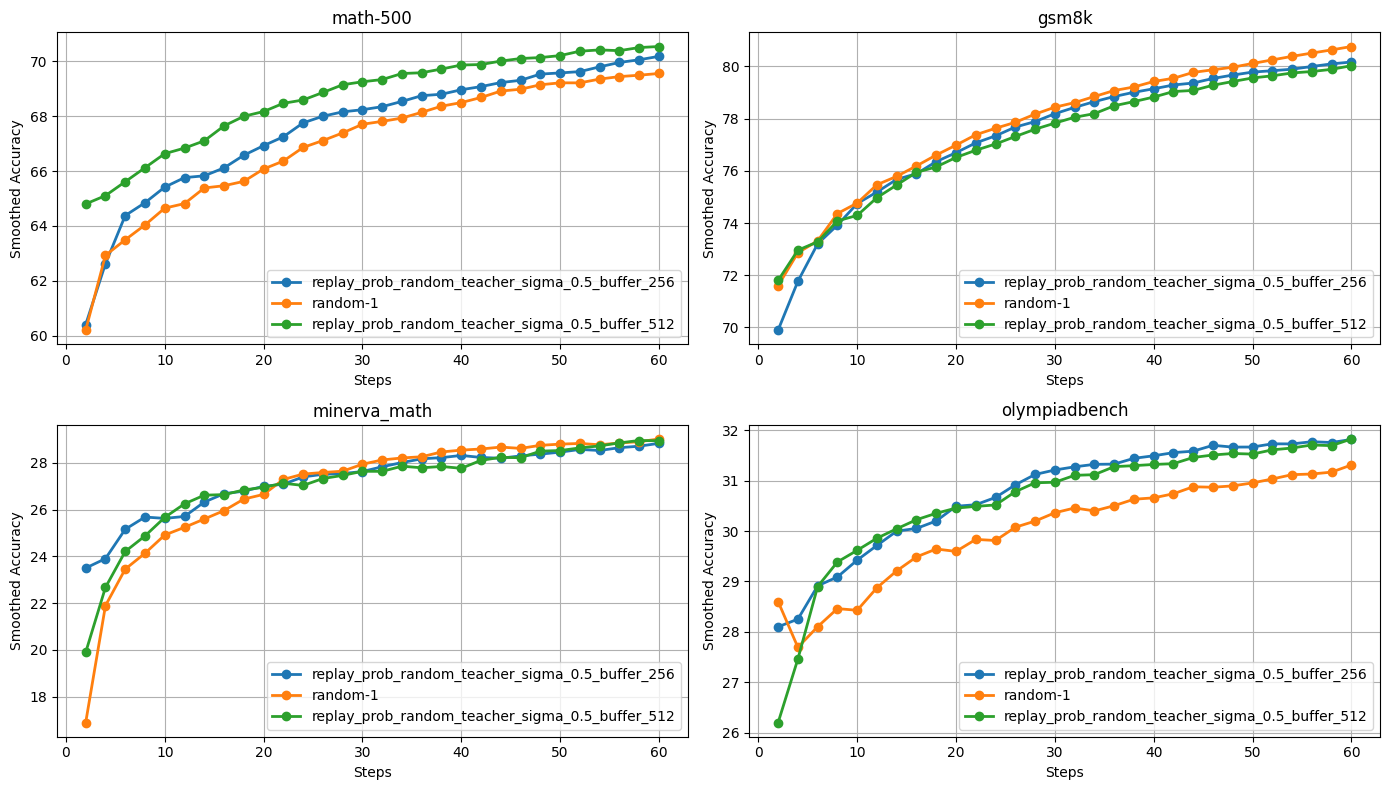

Evaluation Data,gsm8k,math-500,minerva_math,olympiadbench,Average
Method,,,,,
random-1,80.76,69.56,29.02,31.31,52.66
replay_prob_random_teacher_sigma_0.5_buffer_256,80.17,70.18,28.83,31.82,52.75
replay_prob_random_teacher_sigma_0.5_buffer_512,80.03,70.54,28.94,31.83,52.83


,Evaluation Data,Saved (%)
0,math-500,16.67
1,gsm8k,NaN
2,minerva_math,NaN
3,olympiadbench,43.33
4,Average,30.00


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display

def get_results(train_data_name):
    if isinstance(train_data_name, str):
        df_subset = df[df["Train Data"] == train_data_name]
    else:
        df_subset = df[df["Train Data"].isin(train_data_name)]
        df_subset = df[df["Train Data"].isin(train_data_name)].copy()
        df_subset["Method"] = df_subset["Method"] + "_" + df_subset["Train Data"]

    smoothing_param = 0.99
    viewport_scale = 100

    def smoothing(x, y, smoothing_param=0.99, viewport_scale=100):
        assert len(x) == len(y)
        if len(x) == 0:
            return np.array([])

        smoothing_weight = min(np.sqrt(smoothing_param), 0.999)
        range_of_x = max(x) - min(x) if max(x) != min(x) else 1e-8

        smoothed = []
        last_y = 0.0
        debias_weight = 0.0

        for i in range(len(y)):
            prev_i = i - 1 if i > 0 else 0
            delta_x = (x[i] - x[prev_i]) / range_of_x * viewport_scale
            smoothing_weight_adj = smoothing_weight ** delta_x

            last_y = last_y * smoothing_weight_adj + y[i]
            debias_weight = debias_weight * smoothing_weight_adj + 1
            smoothed.append(last_y / debias_weight)

        return np.array(smoothed)

    n_cols = 2
    n_rows = (len(eval_data_filter) + 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
    axes = axes.flatten()  

    results = [] 

    for i, eval_data in enumerate(eval_data_filter):
        ax = axes[i]
        subset = df_subset[df_subset["Evaluation Data"] == eval_data]

        for method in subset["Method"].unique():
            if skip_list is not None and method in skip_list:
                continue
            if show_list is not None and method not in show_list:
                continue
            method_df = subset[subset["Method"] == method]
            # assert(len(method_df) == 30)
            print(eval_data, method, len(method_df))
            method_df = method_df.sort_values("steps")

            x = method_df["steps"].tolist()
            y = method_df["Accuracy"].tolist()
            y_smooth = smoothing(x, y, smoothing_param=smoothing_param, viewport_scale=viewport_scale)

            final_acc = round(y_smooth[-1], 4) if len(y_smooth) > 0 else np.nan
            results.append((eval_data, method, final_acc))  

            ax.plot(x, y_smooth, label=method, linewidth=2, marker='o')

        ax.set_title(f"{eval_data}")
        ax.set_xlabel("Steps")
        ax.set_ylabel("Smoothed Accuracy")
        ax.grid(True)
        ax.legend()

    for j in range(len(eval_data_filter), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    efficiency_results = []

    for eval_data in eval_data_filter:
        subset = df_subset[df_subset["Evaluation Data"] == eval_data]

        rand_df = subset[subset["Method"] == "random-1"].sort_values("steps")
        if len(rand_df) == 0:
            continue
        x_rand = rand_df["steps"].tolist()
        y_rand = rand_df["Accuracy"].tolist()
        y_rand_smooth = smoothing(x_rand, y_rand, smoothing_param=smoothing_param, viewport_scale=viewport_scale)
        acc_target = y_rand_smooth[-1]
        step_rand_final = x_rand[-1]

        ours_df = subset[subset["Method"] == "replay_prob_random_teacher_sigma_0.5_buffer_256"].sort_values("steps")
        if len(ours_df) == 0:
            continue
        x_ours = ours_df["steps"].tolist()
        y_ours = ours_df["Accuracy"].tolist()
        y_ours_smooth = smoothing(x_ours, y_ours, smoothing_param=smoothing_param, viewport_scale=viewport_scale)

        try:
            first_meeting_idx = next(i for i, acc in enumerate(y_ours_smooth) if acc >= acc_target)
            step_ours_needed = x_ours[first_meeting_idx]
            percent_saved = 1 - (step_ours_needed / step_rand_final)
            percent_saved = round(percent_saved * 100, 2)
        except StopIteration:
            percent_saved = None  

        efficiency_results.append((eval_data, percent_saved))

    df_saved = pd.DataFrame(efficiency_results, columns=["Evaluation Data", "Saved (%)"])
    average_saved = round(df_saved["Saved (%)"].mean(skipna=True), 2)
    df_saved.loc[len(df_saved)] = ["Average", average_saved]

    df_result = pd.DataFrame(results, columns=["Evaluation Data", "Method", "Final Smoothed Accuracy"])
    df_pivot = df_result.pivot(index="Method", columns="Evaluation Data", values="Final Smoothed Accuracy")
    df_pivot["Average"] = df_pivot.mean(axis=1, skipna=True)

    display(df_pivot.round(2))  
    display(df_saved)


get_results('math_hard_8192')
# get_results('orz_9728')
# get_results('deepscaler_10240')
# get_results("deepmath_8192")

In [3]:
def plot_overall_average_curve(df, train_data_list, eval_data_list, smoothing_param=0.99, viewport_scale=100, show_list=None, skip_list=None):
    from IPython.display import display
    import matplotlib.pyplot as plt
    import numpy as np

    def smoothing(x, y, smoothing_param=0.99, viewport_scale=100):
        assert len(x) == len(y)
        if len(x) == 0:
            return np.array([])
        smoothing_weight = min(np.sqrt(smoothing_param), 0.999)
        range_of_x = max(x) - min(x) if max(x) != min(x) else 1e-8
        smoothed = []
        last_y = 0.0
        debias_weight = 0.0
        for i in range(len(y)):
            prev_i = i - 1 if i > 0 else 0
            delta_x = (x[i] - x[prev_i]) / range_of_x * viewport_scale
            smoothing_weight_adj = smoothing_weight ** delta_x
            last_y = last_y * smoothing_weight_adj + y[i]
            debias_weight = debias_weight * smoothing_weight_adj + 1
            smoothed.append(last_y / debias_weight)
        return np.array(smoothed)

    df_subset = df[df["Train Data"].isin(train_data_list)].copy()
    if len(train_data_list) > 1:
        df_subset["Method"] = df_subset["Method"] + "_" + df_subset["Train Data"]

    # Plot average smoothed accuracy
    fig, ax = plt.subplots(figsize=(8, 6))
    for method in df_subset["Method"].unique():
        if skip_list and method in skip_list:
            continue
        if show_list and method not in show_list:
            continue

        step_to_accs = {}
        for eval_data in eval_data_list:
            sub_df = df_subset[(df_subset["Evaluation Data"] == eval_data) & (df_subset["Method"] == method)]
            if sub_df.empty:
                continue
            sub_df = sub_df.sort_values("steps")
            x = sub_df["steps"].tolist()
            y = sub_df["Accuracy"].tolist()
            y_smooth = smoothing(x, y, smoothing_param=smoothing_param, viewport_scale=viewport_scale)
            for step, acc in zip(x, y_smooth):
                step_to_accs.setdefault(step, []).append(acc)

        if not step_to_accs:
            continue

        sorted_steps = sorted(step_to_accs.keys())
        avg_accs = [np.mean(step_to_accs[step]) for step in sorted_steps]
        ax.plot(sorted_steps, avg_accs, label=method, linewidth=2, marker='o')

    ax.set_title(f"Average Smoothed Accuracy Across Benchmarks ({train_data_list[0]})")
    ax.set_xlabel("Steps")
    ax.set_ylabel("Avg Accuracy")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Efficiency comparison
    efficiency_results = []
    for eval_data in eval_data_list:
        base_df = df_subset[df_subset["Evaluation Data"] == eval_data]
        rand_df = base_df[base_df["Method"].str.contains("random-1")].sort_values("steps")
        if rand_df.empty:
            continue
        x_rand = rand_df["steps"].tolist()
        y_rand = rand_df["Accuracy"].tolist()
        y_rand_smooth = smoothing(x_rand, y_rand, smoothing_param=smoothing_param, viewport_scale=viewport_scale)
        acc_target = y_rand_smooth[-1]
        step_rand_final = x_rand[-1]

        for method in base_df["Method"].unique():
            if "random-1" in method:
                continue
            if show_list and method not in show_list:
                continue
            if skip_list and method in skip_list:
                continue
            method_df = base_df[base_df["Method"] == method].sort_values("steps")
            if method_df.empty:
                continue
            x = method_df["steps"].tolist()
            y = method_df["Accuracy"].tolist()
            y_smooth = smoothing(x, y, smoothing_param=smoothing_param, viewport_scale=viewport_scale)
            try:
                first_meeting_idx = next(i for i, acc in enumerate(y_smooth) if acc >= acc_target)
                step_needed = x[first_meeting_idx]
                percent_saved = round((1 - step_needed / step_rand_final) * 100, 2)
                efficiency_results.append((eval_data, method, percent_saved))
            except StopIteration:
                continue

    df_eff = pd.DataFrame(efficiency_results, columns=["Evaluation Data", "Method", "Saved (%)"])
    df_summary = df_eff.groupby("Method")["Saved (%)"].mean().reset_index()
    df_summary.loc[len(df_summary)] = ["Average", df_summary["Saved (%)"].mean()]
    display(df_summary.round(2))


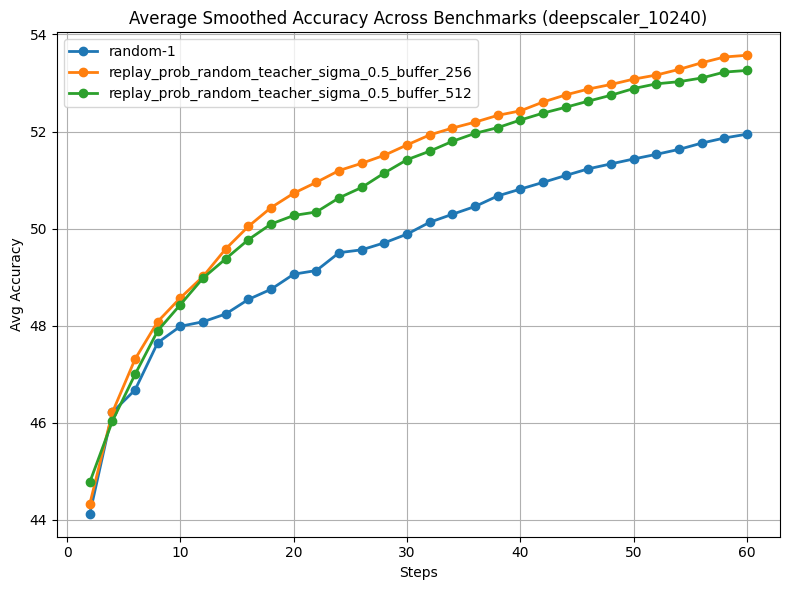

,Method,Saved (%)
0,replay_prob_random_teacher_sigma_0.5_buffer_256,42.50
1,replay_prob_random_teacher_sigma_0.5_buffer_512,38.34
2,Average,40.42


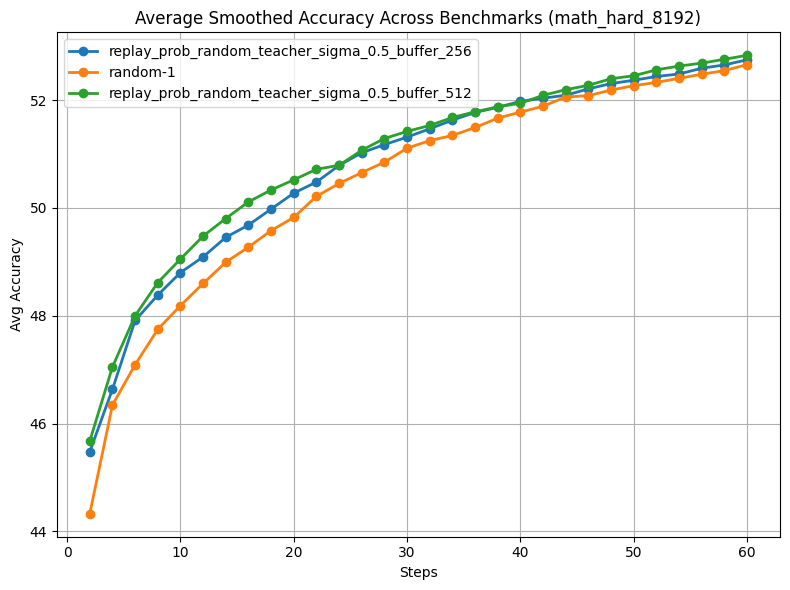

,Method,Saved (%)
0,replay_prob_random_teacher_sigma_0.5_buffer_256,30.00
1,replay_prob_random_teacher_sigma_0.5_buffer_512,36.66
2,Average,33.33


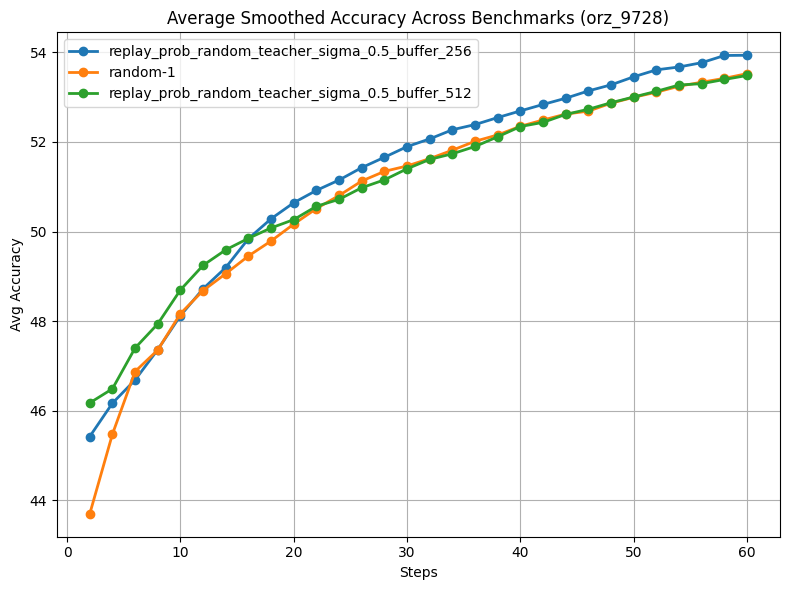

,Method,Saved (%)
0,replay_prob_random_teacher_sigma_0.5_buffer_256,12.50
1,replay_prob_random_teacher_sigma_0.5_buffer_512,6.66
2,Average,9.58


In [4]:
for plot_data in ["deepscaler_10240", 'math_hard_8192', 'orz_9728']:
    plot_overall_average_curve(
        df=df,
        train_data_list=[plot_data],
        eval_data_list=["math-500", "gsm8k", "olympiadbench","minerva_math"],
        show_list=None
    )